First importing everything I need (and then some):

In [91]:
import sys
import os
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sea
import geodatasets as gds
import fiona #geopandas needs this for shapefiles
from geopy.distance import geodesic
from matplotlib import colormaps

I also want pandas to NOT output integers as exponents:

In [70]:
pd.set_option('display.float_format', '{:.0f}'.format)

Now we prepare to make our dataframes:

In [71]:
files = os.listdir()
files_csv = [f for f in files if f[-3:] == 'csv']
print('CSV files: ',files_csv)

CSV files:  ['2022crime.csv', '2020uninsured.csv']


In [72]:
df_crime = pd.read_csv('2022crime.csv') #create Crime dataframe
df_uninsured = pd.read_csv('2020uninsured.csv') #create Uninsured dataframe

In [73]:
#Get Info first
df_crime.info()
df_uninsured.info()

#The most common reason for an 'object' dtype is that the column holds different types of data. 
#Pandas is known for using 'object' as a catch-all for columns that don't fit into a specific numeric or string type. 
#However, a quirk of Pandas is ALSO to label "string" datatypes as "objects." 
#First, We're going to check the dtypes in these object columns.

obj_cols_crime = df_crime.select_dtypes(include='object').columns
obj_cols_uninsured = df_uninsured.select_dtypes(include='object').columns

for n in obj_cols_crime:
    if n in df_crime.columns:
        print(f"In df_crime: {df_crime[n].apply(type).value_counts()}\n")
        
for n in obj_cols_uninsured:
    if n in df_uninsured.columns:
        print(f"In df_uninsured: {df_uninsured[n].apply(type).value_counts()}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NAME                                  133 non-null    object 
 1   Population                            121 non-null    float64
 2   Pers_Aggravat_Assault                 113 non-null    float64
 3   Pers_Simple_Assault                   113 non-null    float64
 4   Pers_Intimidation                     113 non-null    float64
 5   Pers_Murder_Nneglig_Manslaughter      113 non-null    float64
 6   Pers_Negligent_Manslaughter           113 non-null    float64
 7   Pers_Human_Traffic_Commercial_Sex     113 non-null    float64
 8   Pers_Human_Traffic_Invol_Serv         113 non-null    float64
 9   Pers_Kidnap_Abduct                    113 non-null    float64
 10  Pers_Rape                             113 non-null    float64
 11  Pers_Sodomy        

In [74]:
#And if all are strings, run code to officially convert all "object" datatypes to "string" datatypes:
obj_cols_crime = df_crime.select_dtypes(include='object').columns

for n in obj_cols_crime:
    if n in df_crime.columns:
        df_crime[n] = df_crime[n].astype("string")
df_crime.info()

obj_cols_uninsured = df_uninsured.select_dtypes(include='object').columns

for n in obj_cols_uninsured:
    if n in df_uninsured.columns:
        df_uninsured[n] = df_uninsured[n].astype("string")
        
df_uninsured['GEOID20'] = df_uninsured['GEOID20'].astype("string")

df_uninsured.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   NAME                                  133 non-null    string 
 1   Population                            121 non-null    float64
 2   Pers_Aggravat_Assault                 113 non-null    float64
 3   Pers_Simple_Assault                   113 non-null    float64
 4   Pers_Intimidation                     113 non-null    float64
 5   Pers_Murder_Nneglig_Manslaughter      113 non-null    float64
 6   Pers_Negligent_Manslaughter           113 non-null    float64
 7   Pers_Human_Traffic_Commercial_Sex     113 non-null    float64
 8   Pers_Human_Traffic_Invol_Serv         113 non-null    float64
 9   Pers_Kidnap_Abduct                    113 non-null    float64
 10  Pers_Rape                             113 non-null    float64
 11  Pers_Sodomy        

And we import our maps

In [75]:
#If we want to represent everything on a map of Utah, here is a basemap of Utah Census Tracts, imported

#CENSUS TRACT BASEMAP
utct_base = r"/Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/CensusTracts2020.shp"
df_utct_base = gpd.read_file(utct_base)

#LAW ENFORCEMENT BOUNDARIES BASEMAP
utle_base = r"/Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/LawEnforcementBoundaries.shp"
df_utle_base = gpd.read_file(utle_base)

#Then I sought column labels and datatypes ... 
df_utct_base.info()
df_utle_base.info()

# ... and for "Object" datatypes, make sure all are strings:
obj_cols_ct_base = df_utct_base.select_dtypes(include='object').columns
for n in obj_cols_ct_base:
    if n in df_utct_base.columns:
        print(f"In df_utct_base {n}: {df_utct_base[n].apply(type).value_counts()}\n")
        
obj_cols_le_base = df_utle_base.select_dtypes(include='object').columns
for n in obj_cols_le_base:
    if n in df_utle_base.columns:
        print(f"In df_utle_base {n}: {df_utle_base[n].apply(type).value_counts()}\n")

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP20   716 non-null    object  
 1   COUNTYFP20  716 non-null    object  
 2   TRACTCE20   716 non-null    object  
 3   GEOID20     716 non-null    object  
 4   NAME20      716 non-null    object  
 5   NAMELSAD20  716 non-null    object  
 6   MTFCC20     716 non-null    object  
 7   FUNCSTAT20  716 non-null    object  
 8   ALAND20     716 non-null    float64 
 9   AWATER20    716 non-null    float64 
 10  INTPTLAT20  716 non-null    object  
 11  INTPTLON20  716 non-null    object  
 12  POP100      716 non-null    int32   
 13  HU100       716 non-null    int32   
 14  geometry    716 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(10)
memory usage: 78.4+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (to

/Users/kristinknippenberg/Library/Python/3.9/lib/python/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/kristinknippenberg/My Drive/0_BIOINFORMATICS/BMI 6016 Data Wrangling/Group 4 Project/LawEnforcementBoundaries.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [92]:
#And then change all Objects to Strings, so we can layer csv files on:
obj_cols_ct_base = df_utct_base.select_dtypes(include='object').columns
obj_cols_le_base = df_utle_base.select_dtypes(include='object').columns

for m in obj_cols_ct_base:
    if m in df_utct_base.columns:
        df_utct_base[m] = df_utct_base[m].astype("string")
df_utct_base.info()

for n in obj_cols_le_base:
    if n in df_utle_base.columns:
        df_utle_base[n] = df_utle_base[n].astype("string")
df_utle_base.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP20   716 non-null    string  
 1   COUNTYFP20  716 non-null    string  
 2   TRACTCE20   716 non-null    string  
 3   GEOID20     716 non-null    string  
 4   NAME20      716 non-null    string  
 5   NAMELSAD20  716 non-null    string  
 6   MTFCC20     716 non-null    string  
 7   FUNCSTAT20  716 non-null    string  
 8   ALAND20     716 non-null    float64 
 9   AWATER20    716 non-null    float64 
 10  INTPTLAT20  716 non-null    string  
 11  INTPTLON20  716 non-null    string  
 12  POP100      716 non-null    int32   
 13  HU100       716 non-null    int32   
 14  geometry    716 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), string(10)
memory usage: 78.4 KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (tot

In [93]:
#And now to transform the crime data into a new dataframe that uses total population and represents as 'per 1000':

crime_per1K = {}

for c in df_crime.columns:
    if c not in ['NAME', 'Population']:
        crime_per1K[c] = (df_crime[c] / df_crime['Population']) *1000
        
df_crime_per1K = pd.DataFrame(crime_per1K)
df_crime_per1K['NAME'] = df_crime['NAME']
df_crime_per1K['Population'] = df_crime['Population']
df_crime_per1K = df_crime_per1K[['NAME', 'Population'] + [col for col in df_crime_per1K.columns if col not in ['NAME', 'Population']]]


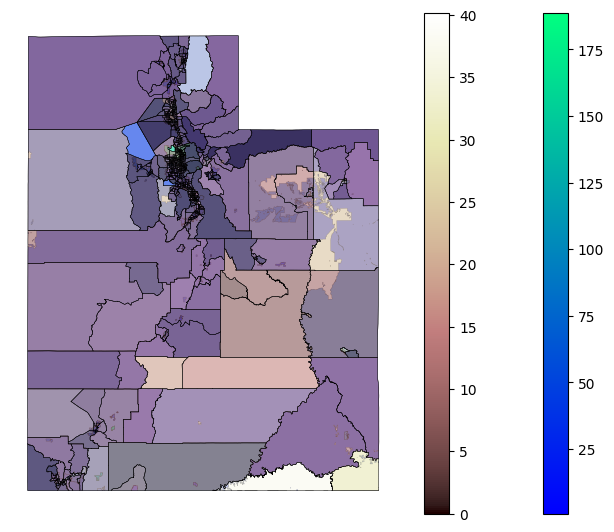

In [94]:
# Plot base layers (census tract and law enforcement) and additional data layers dynamically
def df_ut_base(*layers):
    ax = df_utct_base.boundary.plot(
        figsize=(9,6.5),
        linewidth=0.25,
        facecolor='none',
        edgecolor="000000"
    )
    df_utle_base.plot( # Plot the law enforcement map onto Census Tract Map
        ax=ax,  # Plot this dataframe on top of the boundary plot
        edgecolor="none",
        facecolor="none"
    )
    
    ax.set_axis_off()  
    return ax  # Return the axis to plot further layers on top

# Prepare crime data for plotting
df_crime_hm = pd.merge(df_utle_base, df_crime_per1K, on='NAME')

# Prepare uninsured data for plotting
df_uninsured_hm = pd.merge(df_utct_base, df_uninsured, on='GEOID20')

ax = df_ut_base()

#Plot crime layer
crime_layer = df_crime_hm.plot(
    ax=ax,  # Plot the merged dataframe on top of the boundary plot
    column='Total',  # Plot the 'Total' column (ensure it exists)
    linewidth=0.25,
    edgecolor="000000",
    cmap='winter',
    alpha=0.6,
    legend=True
    
)

#Plot uninsured layer
uninsured_layer = df_uninsured_hm.plot(
    ax=ax,  # Plot the merged dataframe on top of the boundary plot
    column='ACS_PCT_UNINSURED',  # Plot the 'Total' column (ensure it exists)
    linewidth=0.25,
    edgecolor="000000",
    cmap='pink',
    alpha=0.6,
    legend=True
)

plt.show()